# legends - Stlr features
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Jan 24, 2022

## Hypothesis
The goal of this notebook is to compare the results of the model with the model using standard StellarAlgo features with the engineered retention model features.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 26 # legends
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMILB].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(265, 54)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            265 non-null    int64  
 1   dimCustomerMasterId     265 non-null    int64  
 2   customerNumber          265 non-null    object 
 3   year                    265 non-null    int64  
 4   productGrouping         265 non-null    object 
 5   totalSpent              265 non-null    float64
 6   recentDate              265 non-null    object 
 7   attendancePercent       265 non-null    float64
 8   renewedBeforeDays       265 non-null    int64  
 9   isBuyer                 265 non-null    object 
 10  source_tenure           265 non-null    int64  
 11  tenure                  265 non-null    int64  
 12  distToVenue             265 non-null    float64
 13  totalGames              265 non-null    int64  
 14  recency                 265 non-null    in

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
                "attendancePercent",
                "distToVenue",
                "missed_games_1",
                "missed_games_2",
                "missed_games_over_2",
                "totalSpent",
                "recency",
                "source_tenure",
                "renewedBeforeDays",
                "isNextYear_Buyer",
                "productGrouping",
                "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (212, 13)
Unseen Data For Predictions: (37, 13)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
    "attendancePercent",
                "distToVenue",
                "missed_games_1",
                "missed_games_2",
                "missed_games_over_2",
                "totalSpent",
                "recency",
                "source_tenure",
                "renewedBeforeDays"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7167,0.7184,0.8689,0.7400,0.7957,0.3434,0.3581,0.4220
xgboost,Extreme Gradient Boosting,0.6944,0.7450,0.7962,0.7486,0.7657,0.3178,0.3310,0.1810


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6111,0.6623,0.9091,0.6250,0.7407,0.0597,0.0806
1,0.7778,0.9221,1.0000,0.7333,0.8462,0.4783,0.5606
2,0.8333,0.8701,0.9091,0.8333,0.8696,0.6400,0.6447
3,0.7778,0.7143,0.9091,0.7692,0.8333,0.5068,0.5230
4,0.6111,0.7143,0.9091,0.6250,0.7407,0.0597,0.0806
5,0.7778,0.7273,0.8182,0.8182,0.8182,0.5325,0.5325
6,0.7222,0.7403,0.8182,0.7500,0.7826,0.4000,0.4029
7,0.5556,0.4167,0.7500,0.6429,0.6923,-0.0909,-0.0945
8,0.7778,0.7361,0.8333,0.8333,0.8333,0.5000,0.5000
9,0.7222,0.6806,0.8333,0.7692,0.8000,0.3478,0.3508


### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(16, 54)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
249,26,320263357,1138331,2021,Full Season,798.0,1970-01-01,0.000000,61,TRUE,...,0,0,0.0,1,132,0,0,0,0.6502,0.3498
250,26,352544446,1205719,2021,Full Season,1330.8,2021-08-07,0.161017,15,TRUE,...,0,0,0.0,1,132,0,0,1,0.4619,0.5381
251,26,355872477,261734,2021,Full Season,798.0,2021-09-30,0.677966,61,TRUE,...,0,0,0.0,1,132,0,0,1,0.4037,0.5963
252,26,355950513,154960,2021,Full Season,1064.4,2021-09-30,0.042373,0,TRUE,...,0,0,0.0,1,132,0,0,0,0.8132,0.1868
253,26,355950516,855851,2021,Full Season,1980.0,2021-06-01,0.012712,43,TRUE,...,0,0,0.0,1,132,0,0,0,0.6824,0.3176


In [11]:
new_predictions["Label"].value_counts()

0    10
1     6
Name: Label, dtype: int64

In [12]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    5
(0.2, 0.4]       4
(0.4, 0.6]       4
(0.6, 0.8]       3
(0.8, 1.0]       0
Name: Score_1, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

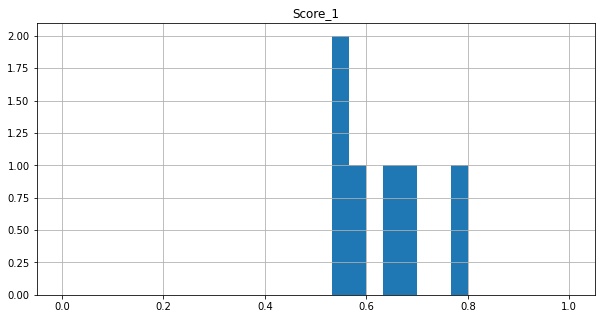

In [13]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

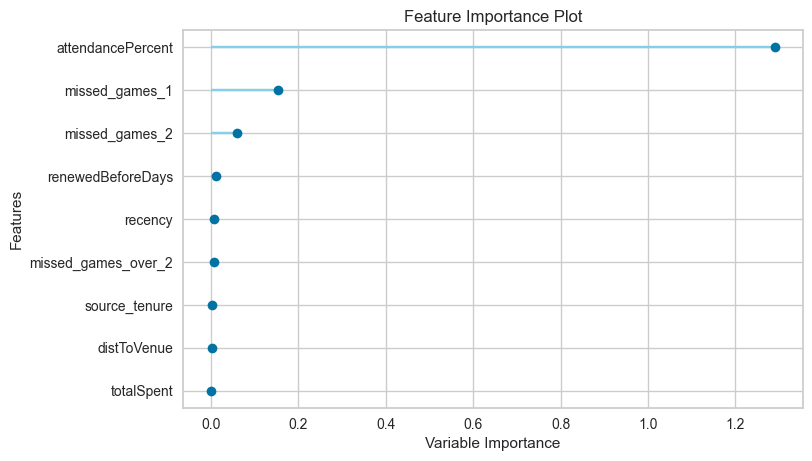

In [14]:
plot_model(best_model, plot='feature')

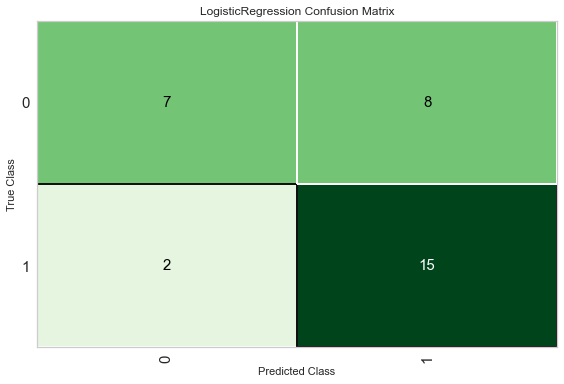

In [15]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above

* the distribution doesn't look normal
* The ticketing data are in the top 3 feature importance
* The model makes more predictions of customers who won't buy
* The accuracy and the AUC decreased compared to using Full Season product

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?